# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning  迁移学习--微调

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

fine-tuning 迁移学习，也就是说，在微调迁移学习中，我们只是微调一些层，而不是所有的层。1-3+的层可以微调。取决于具体情况

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*



## What we're going to cover 

- fine-tuning 介绍
- 使用Keras Functional API构建模型
- 使用更少的数据进行实验（例如10%的训练样本和10个类别的图像）
- 数据增强（如何使训练数据更加 diversified 而不是添加更多数据）
- 运行一系列的模型实验
  - **Model 0**: 使用Keras Functional API构建的预训练模型
  - **Model 1**: 使用1%的数据进行特征提取的预训练模型
  - **Model2**: 使用10%的数据进行特征提取的预训练模型
  - **Model3**: 使用10%的数据进行fine-tuning的预训练模型
  - **Model4**: 使用100%的数据进行fine-tuning的预训练模型
- 使用ModelCheckpoint回调保存中间训练结果
- 使用TensorBoard比较模型实验结果

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data  
- Using the Keras Functional API (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - **Model 0**: a transfer learning model using the Keras Functional API
  - **Model 1**: a feature extraction transfer learning model on 1% of the data with data augmentation
  - **Model 2**: a feature extraction transfer learning model on 10% of the data with data augmentation
  - **Model 3**: a fine-tuned transfer learning model on 10% of the data
  - **Model 4**: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard


In [3]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2025-01-09 10:26:54.070712


In [4]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

2025-01-09 10:26:54.246643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-09 10:26:54.246665: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.7.0


In [5]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Creating helper functions

Throughout your machine learning experiments, you'll likely come across snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And then import the necesary functionality when you need it.

For example, you might write:

```
from helper_functions import plot_loss_curves

...

plot_loss_curves(history)
```

Let's see what this looks like.

In [6]:
import os 
if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [7]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## 10 Food Classes: Working with less data  更少的数据训练

We saw in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) which is part of the [`tf.keras.utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils) module.

Finally, we'll also be practicing using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [8]:
# Get 10% of the data of the 10 classes
import os
if not os.path.exists("10_food_classes_10_percent"):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

In [9]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [10]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

使用`tf.keras.preprocessing.image_dataset_from_directory()`而不是`ImageDataGenerator`。生成tf.data.Dataset对象而不是ImageDataGenerator。训练效率更高

Because of this, we'll move onto using `tf.keras.utils.image_dataset_from_directory()`.

This method expects image data in the following file format:

```
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

One of the main benefits of using [`tf.keras.prepreprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) rather than `ImageDataGenerator` is that it creates a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object rather than a generator.

The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.

Let's see it in action.



In [12]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


For now, the main parameters we're concerned about in the `image_dataset_from_directory()` funtion are:  目录、`image_size` and `batch_size`三个参数
* `directory` - the filepath of the target directory we're loading images in from.
* `image_size` - the target size of the images we're going to load in (height, width).
* `batch_size` - the batch size of the images we're going to load in. For example if the `batch_size` is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

There are more we could play around with if we needed to [in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

If we check the training data datatype we should see it as a `BatchDataset` with shapes relating to our data.

In [14]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In the above output:  (None, 224, 224, 3) batch size, height, width, color channels ,(None, 10) bathc size, number of classes

* `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and `3` is the color channels (red, green, blue).
* `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [15]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [16]:
# 查看其中一个样本
for images ,labels in train_data_10_percent.take(1):
    print(images.shape,labels.shape)
    print(images,labels)
    break

(32, 224, 224, 3) (32, 10)
tf.Tensor(
[[[[7.23520355e+01 9.04081650e+01 8.59234695e+01]
   [2.11938725e+01 3.59336662e+01 3.99132614e+01]
   [3.28112259e+01 4.23826523e+01 5.25969391e+01]
   ...
   [8.53520737e+01 8.44948807e+01 9.70000000e+01]
   [8.37857437e+01 8.25000229e+01 9.51428833e+01]
   [8.51581192e+01 8.18723984e+01 9.55152588e+01]]

  [[1.03719391e+02 1.18433678e+02 1.12698982e+02]
   [2.94030590e+01 4.05969353e+01 4.41734657e+01]
   [2.88163280e+01 3.88163261e+01 4.92448959e+01]
   ...
   [8.45714493e+01 8.73265152e+01 9.89846954e+01]
   [8.29949265e+01 8.53520660e+01 9.72092056e+01]
   [8.30713577e+01 8.54285049e+01 9.72856445e+01]]

  [[1.02255104e+02 1.10112244e+02 1.03326530e+02]
   [2.66224327e+01 3.67652893e+01 3.77091675e+01]
   [2.82295933e+01 3.85663261e+01 4.89948997e+01]
   ...
   [8.02143097e+01 8.87857361e+01 9.80000229e+01]
   [7.86581650e+01 8.72295914e+01 9.64438782e+01]
   [7.71427917e+01 8.57142181e+01 9.49285049e+01]]

  ...

  [[5.70714455e+01 5.6071445

### Model 0: Building a transfer learning model using the Keras Functional API  用Keras函数式API构建迁移学习模型

1、初始化预训练模型，2、冻结参数，3、添加输入层，4、归一化，5、输入进入到预训练模型，6、池化、7、添加输出层，8、编译模型，9、采用相近的loss和破题密责任，10、训练模型

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0) from [`tf.keras.applications.efficientnet_v2`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2), setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1.

> 🤔 **Note:** As of writing, the `EfficientNet` (and `EfficientNetV2`) models in the `tf.keras.applications` module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. I posted [an issue to the TensorFlow GitHub](https://github.com/tensorflow/tensorflow/issues/42506) about this and they confirmed this.

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [19]:
# 1、预训练模型
# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2、冻结参数
base_model.trainable = False

# 3、添加输入层
inputs = tf.keras.Input(shape=(224, 224, 3),name="input_layer")

# 4、归一化
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5、传递参数
x = base_model(inputs)
print(f"after base model shape: {x.shape}"  )

# 6、池化
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"after  GlobalAveragePooling2D shape: {x.shape}"  )

# 7、添加输出层
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8、创建模型
model0 = tf.keras.Model(inputs, outputs)

# 9、模型编译
model0.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
# 10、模型训练
history0 = model0.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data_10_percent,
                    validation_steps=int(len(test_data_10_percent)*0.25),
                    callbacks=[create_tensorboard_callback('transfer_learning','10_percent_feature_extract')]
                    )

16719872/16705208 [==============================] - 3s 0us/step
after base model shape: (None, 7, 7, 1280)
after  GlobalAveragePooling2D shape: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20250109-131302
Epoch 1/5


/root/miniconda3/envs/torchai/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 18s 645ms/step - loss: 1.8979 - accuracy: 0.3947 - val_loss: 1.3429 - val_accuracy: 0.7105
Epoch 2/5
24/24 [==============================] - 14s 608ms/step - loss: 1.1596 - accuracy: 0.7533 - val_loss: 0.9075 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 14s 610ms/step - loss: 0.8452 - accuracy: 0.8040 - val_loss: 0.7511 - val_accuracy: 0.8141
Epoch 4/5
24/24 [==============================] - 14s 608ms/step - loss: 0.6949 - accuracy: 0.8360 - val_loss: 0.6732 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 15s 613ms/step - loss: 0.6046 - accuracy: 0.8560 - val_loss: 0.6110 - val_accuracy: 0.8355


迁移学习可以，1分钟的简单训练即可实现很好的效果；

用keras Function 构建模型，而不是Sequential，

Nice! After a minute or so of training our model performs incredibly well on both the training and test sets.

This is incredible.

All thanks to the power of transfer learning!

It's important to note the kind of transfer learning we used here is called feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetV2B0`), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

> 📖 **Resource:** To see the benefits and use cases of the Functional API versus the Sequential API, check out the [TensorFlow Functional API documentation](https://www.tensorflow.org/guide/keras/functional).

Let's inspect the layers in our model, we'll start with the base.

In [20]:
for i,layer in enumerate(model0.layers):
    print(i,layer.name)

0 input_layer
1 efficientnetb0
2 global_average_pooling_layer
3 output_layer


In [21]:
model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


<Axes: >

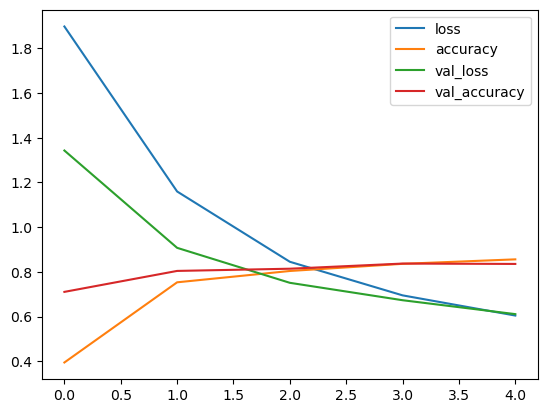

In [22]:
import pandas as pd
pd.DataFrame(history0.history).plot()

## Getting a feature vector from a trained model  预训练模型抽取特征向量

GlobalAveragePooling2D 将4D张量转换为2D张量

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [24]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"input_tensor: {input_tensor}")

global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"global_average_pooling_layer: {global_average_pooling_layer}")
print(f"input_tensor shape: {input_tensor.shape}")
print(f"global_average_pooling_layer shape: {global_average_pooling_layer.shape}")

input_tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]
global_average_pooling_layer: [[-0.09368646 -0.45840445 -0.28855976]]
input_tensor shape: (1, 4, 4, 3)
global_average_pooling_layer shape: (1, 3)


In [ ]:
# 和global_average_pooling2d效果相同，求平均值
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

预训练模型，得到特征向量，很适合做类似的分类工作

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer) which can then be used to extract patterns out of.

> 🛠 **Practice:** Do the same as the above cell but for [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

## Running a series of transfer learning experiments 一系列的 transfer learning实验

1、model1 1%的数据，数据增强，特征抽取迁移学习，
2、model1 10%的数据，数据增强，特征抽取迁移学习，保存checkpoint
3、model3 10%的数据，数据增强，在model2，fine-tune
4、model4 10%的数据，数据增强，在model2，fine-tune

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. **Model 1**: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. **Model 2**: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. **Model 3**: Fine-tune the **Model 2** checkpoint on 10% of the training data with data augmentation.
4. **Model 4**: Fine-tune the **Model 2** checkpoint on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the **same test dataset**, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetV2B0` model within the `tf.keras.applications.efficientnet_v2` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [26]:
if not os.path.exists("10_food_classes_1_percent"):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2025-01-09 13:32:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.211.251, 172.217.14.219, 142.250.217.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.211.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  4.35MB/s    in 26s     

2025-01-09 13:33:13 (4.89 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [27]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [28]:
# 1%，只有7张image

import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model  数据增强，tf.keras.layers可以直接增强

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.10+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

> 📚 **Resource:** For more information on different methods of data augmentation, check out the the [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:
* [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) - flips image on horizontal or vertical axis.
* [`tf.keras.layersRandomRotation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) - randomly rotates image by a specified amount.
* [`tf.keras.layers.RandomZoom`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) - randomly zooms into an image by specified amount.
* [`tf.keras.layers.RandomHeight`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomHeight) - randomly shifts image height by a specified amount.
* [`tf.keras.layers.RandomWidth`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomWidth) - randomly shifts image width by a specified amount.
* [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using [`tf.keras.applications.efficientnet_v2.EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0), it's not required (the model pretrained model implements rescaling itself).

There are more option but these will do for now.

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

# # UPDATE: Previous versions of TensorFlow (e.g. 2.4 and below used the tensorflow.keras.layers.experimental.processing API)
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")


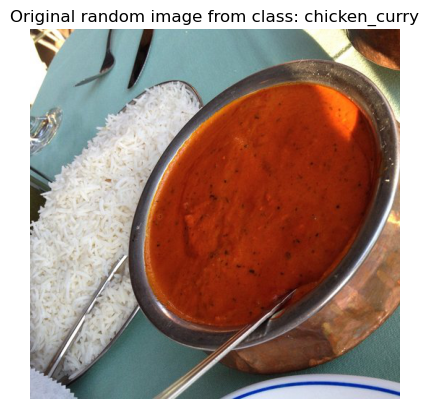

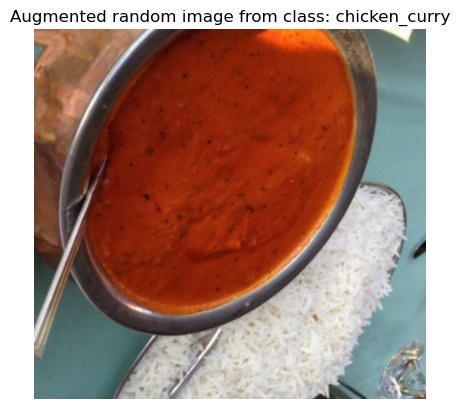

In [30]:
# 测试一个案例
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


## Model 1: 特征向量迁移学习，1%的数据 Feature extraction transfer learning on 1% of the data with data augmentation

In [31]:
# 1、预训练模型
# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2、冻结参数
base_model.trainable = False

# 3、添加输入层
inputs = tf.keras.Input(shape=input_shape,name="input_layer")

# 4、数据增强
x  = data_augmentation(inputs)

# 5、传递参数
x = base_model(inputs)
print(f"after base model shape: {x.shape}"  )

# 6、池化
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"after  GlobalAveragePooling2D shape: {x.shape}"  )

# 7、添加输出层
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8、创建模型
model1 = tf.keras.Model(inputs, outputs)

# 9、模型编译
model1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
# 10、模型训练
history1 = model1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(len(test_data)*0.25),
                    callbacks=[create_tensorboard_callback('transfer_learning','1_percent_feature_extract')]
                    )

after base model shape: (None, 7, 7, 1280)
after  GlobalAveragePooling2D shape: (None, 1280)
Saving TensorBoard log files to: transfer_learning/1_percent_feature_extract/20250109-140644
Epoch 1/5


/root/miniconda3/envs/torchai/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 11s 4s/step - loss: 2.3881 - accuracy: 0.1429 - val_loss: 2.2099 - val_accuracy: 0.1908
Epoch 2/5
3/3 [==============================] - 7s 4s/step - loss: 2.1005 - accuracy: 0.3143 - val_loss: 2.0659 - val_accuracy: 0.2944
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.8453 - accuracy: 0.4429 - val_loss: 1.9392 - val_accuracy: 0.3882
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.6359 - accuracy: 0.6286 - val_loss: 1.8172 - val_accuracy: 0.4868
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5011 - accuracy: 0.7286 - val_loss: 1.7160 - val_accuracy: 0.5444


How cool is that? Using only 7 training images per class, using transfer learning our model was able to get ~45%+ accuracy on the validation set.

This result is pretty amazing since the [original Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) achieved 50.67% accuracy with all the data, namely, 750 training images per class (**note:** this metric was across 101 classes, not 10, we'll get to 101 classes soon).

If we check out a summary of our model, we should see the data augmentation layer just after the input layer.

In [32]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


数据增强的layer的，只在训练中生效，在推理中会自动关闭

There it is. We've now got data augmentation built right into the our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is **data augmentation only runs during training**. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.

In [33]:
results_1_percent_data_aug = model1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 27s 346ms/step - loss: 1.7364 - accuracy: 0.5228


[1.7363749742507935, 0.5228000283241272]

<Axes: >

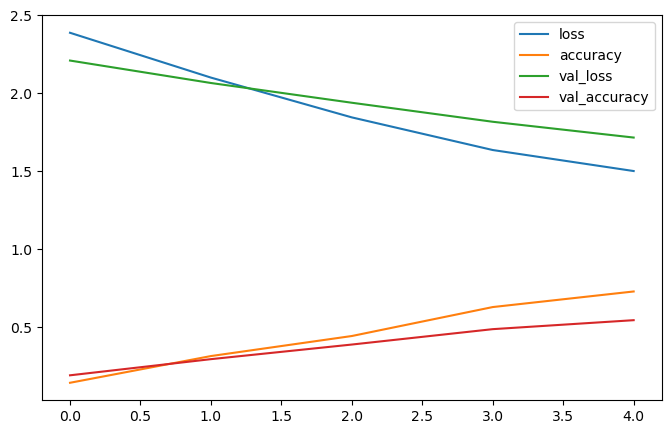

In [34]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))

## Model 2: 特征抽取迁移学习，10% 数据增强 Feature extraction transfer learning with 10% of data and data augmentation

Alright, we've tested 1% of the training data with data augmentation, how about we try 10% of the data with data augmentation?

But wait...

> 🤔 **Question:** How do you know what experiments to run?

Great question.

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that you'll start to develop an intuition of what to try.

My advice is to follow your curiosity as tenaciously as possible. If you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation. That sentence doesn't really make sense but you get what I mean.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

In [35]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [36]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [37]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# 3、添加输入层
inputs = tf.keras.Input(shape=input_shape,name="input_layer")
x  = data_augmentation(inputs)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model

# 6、池化
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
# 8、创建模型
model2 = tf.keras.Model(inputs, outputs)

# 9、模型编译
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [38]:
def create_base_model(input_shape= (224, 224, 3), output_shape=10,learning_rate=0.001,training=False):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False)
    base_model.trainable = training
    
    inputs = tf.keras.Input(shape=input_shape,name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x,training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(output_shape,activation="softmax",name="output_layer")(x)
    model = tf.keras.Model(inputs,outputs)
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    
    return model

model2 = create_base_model()

### Creating a ModelCheckpoint callback  定期checkpoint 的回调函数

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [39]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [40]:
initial_epochs = 5
history2 = model2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250109-150856
Epoch 1/5


/root/miniconda3/envs/torchai/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - ETA: 0s - loss: 2.0036 - accuracy: 0.3480
Epoch 00001: val_loss improved from inf to 1.48368, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 725ms/step - loss: 2.0036 - accuracy: 0.3480 - val_loss: 1.4837 - val_accuracy: 0.6332
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3451 - accuracy: 0.6653
Epoch 00002: val_loss improved from 1.48368 to 1.06331, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 655ms/step - loss: 1.3451 - accuracy: 0.6653 - val_loss: 1.0633 - val_accuracy: 0.7648
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0550 - accuracy: 0.7440
Epoch 00003: val_loss improved from 1.06331 to 0.88376, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 650ms/step - loss: 1.0550 - accuracy: 0.7440 - v

In [41]:
results_10_percent_data_aug = model2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 26s 329ms/step - loss: 0.6948 - accuracy: 0.8144


[0.6948037147521973, 0.8144000172615051]

<Axes: >

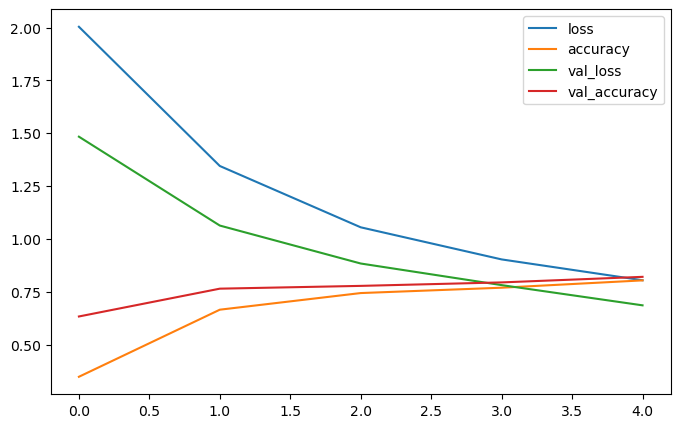

In [42]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))

Since we checkpointed (is that a word?) our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) method, passing it the path where your saved weights are stored.

In [44]:
model2.load_weights(checkpoint_path)
loaded_weights_model_results = model2.evaluate(test_data)

79/79 [==============================] - 26s 331ms/step - loss: 0.6948 - accuracy: 0.8144


In [45]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [47]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [48]:
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (`EfficientNetV2B0`) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

We've verified our loaded model's performance, let's check out its layers.

fine-tuning.底层参数冻结，上层参数训练，在特征抽取迁移模型上进行微调，效果更好；相当于，先冻结全部，训练，总冻结底层层，再训练上层，效果更好。

In [49]:
model2.layers

In [51]:
for i,layer in enumerate(model2.layers):
    print(f"层数: {i} - layer: {layer.name},type: {type(layer)}, trainable: {layer.trainable}")

层数: 0 - layer: input_layer,type: <class 'keras.engine.input_layer.InputLayer'>, trainable: True
层数: 1 - layer: data_augmentation,type: <class 'keras.engine.sequential.Sequential'>, trainable: True
层数: 2 - layer: efficientnetb0,type: <class 'keras.engine.functional.Functional'>, trainable: False
层数: 3 - layer: global_average_pooling2d_2,type: <class 'keras.layers.pooling.GlobalAveragePooling2D'>, trainable: True
层数: 4 - layer: output_layer,type: <class 'keras.layers.core.dense.Dense'>, trainable: True


In [52]:
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

Alright, it looks like all of the layers in the `efficientnetv2-b0` layer are frozen. We can confirm this using the `trainable_variables` attribute.

> **Note:** The layers of `base_model` (our `efficientnetv2-b0` feature extractor) of `model_2` is accessible by referencing `model_2.layers[2]`.

In [54]:
model_2_base_model = model2.layers[2]
model_2_base_model.name

'efficientnetb0'

In [55]:
len(model_2_base_model.trainable_variables)

0

In [56]:
for i,layer in enumerate(model_2_base_model.layers):
    print(f"层数: {i} - layer: {layer.name},type: {type(layer)}, trainable: {layer.trainable}")

层数: 0 - layer: input_4,type: <class 'keras.engine.input_layer.InputLayer'>, trainable: False
层数: 1 - layer: rescaling_3,type: <class 'keras.layers.preprocessing.image_preprocessing.Rescaling'>, trainable: False
层数: 2 - layer: normalization_3,type: <class 'keras.layers.preprocessing.normalization.Normalization'>, trainable: False
层数: 3 - layer: stem_conv_pad,type: <class 'keras.layers.convolutional.ZeroPadding2D'>, trainable: False
层数: 4 - layer: stem_conv,type: <class 'keras.layers.convolutional.Conv2D'>, trainable: False
层数: 5 - layer: stem_bn,type: <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>, trainable: False
层数: 6 - layer: stem_activation,type: <class 'keras.layers.core.activation.Activation'>, trainable: False
层数: 7 - layer: block1a_dwconv,type: <class 'keras.layers.convolutional.DepthwiseConv2D'>, trainable: False
层数: 8 - layer: block1a_bn,type: <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>, trainable: False
层数: 9 - lay

基础模型，将上面的十层放开，底层的仍然冻结；先全部放开，再从底层冻结，只留上面10层

Beautiful. This is exactly what we're after.

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

> 🤔 **Question:** How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

> 📖 **Resource:** The [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146) has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire `model_2_base_model` by setting its `trainable` attribute to `True`.

Then we'll refreeze every layer in `model_2_base_model` except for the last 10 by looping through them and setting their `trainable` attribute to `False`.

Finally, we'll recompile the whole model.

In [59]:
model_2_base_model.trainable = True
# 最后10层设置为可训练
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False
  
model2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [60]:
for i,layer in enumerate(model_2_base_model.layers):
    print(f"层数: {i} - layer: {layer.name},type: {type(layer)}, trainable: {layer.trainable}")

层数: 0 - layer: input_4,type: <class 'keras.engine.input_layer.InputLayer'>, trainable: False
层数: 1 - layer: rescaling_3,type: <class 'keras.layers.preprocessing.image_preprocessing.Rescaling'>, trainable: False
层数: 2 - layer: normalization_3,type: <class 'keras.layers.preprocessing.normalization.Normalization'>, trainable: False
层数: 3 - layer: stem_conv_pad,type: <class 'keras.layers.convolutional.ZeroPadding2D'>, trainable: False
层数: 4 - layer: stem_conv,type: <class 'keras.layers.convolutional.Conv2D'>, trainable: False
层数: 5 - layer: stem_bn,type: <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>, trainable: False
层数: 6 - layer: stem_activation,type: <class 'keras.layers.core.activation.Activation'>, trainable: False
层数: 7 - layer: block1a_dwconv,type: <class 'keras.layers.convolutional.DepthwiseConv2D'>, trainable: False
层数: 8 - layer: block1a_bn,type: <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>, trainable: False
层数: 9 - lay

模型有改变，结构、学习率、优化器等参数都改变，都需要重新编译

Nice! It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

> 🤔 **Question:** Why did we recompile the model?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (`0.0001` instead of Adam's default of `0.001`).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

> 🔑 **Note:** There's no set standard for setting the learning rate during fine-tuning, though reductions of [2.6x-10x+ seem to work well in practice](https://arxiv.org/abs/1801.06146).

How many trainable variables do we have now?

In [62]:
print(len(model2.trainable_variables))

12


In [63]:
# 再训练5轮
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history2.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20250109-153730
Epoch 5/10


/root/miniconda3/envs/torchai/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 19s 701ms/step - loss: 0.6788 - accuracy: 0.8067 - val_loss: 0.5984 - val_accuracy: 0.7993
Epoch 6/10
24/24 [==============================] - 15s 633ms/step - loss: 0.5678 - accuracy: 0.8267 - val_loss: 0.5856 - val_accuracy: 0.8109
Epoch 7/10
24/24 [==============================] - 16s 658ms/step - loss: 0.5002 - accuracy: 0.8440 - val_loss: 0.5628 - val_accuracy: 0.8158
Epoch 8/10
24/24 [==============================] - 15s 630ms/step - loss: 0.4717 - accuracy: 0.8560 - val_loss: 0.5656 - val_accuracy: 0.8141
Epoch 9/10
24/24 [==============================] - 17s 698ms/step - loss: 0.4038 - accuracy: 0.8773 - val_loss: 0.5570 - val_accuracy: 0.8125
Epoch 10/10
24/24 [==============================] - 16s 674ms/step - loss: 0.3844 - accuracy: 0.8787 - val_loss: 0.5175 - val_accuracy: 0.8339


In [64]:
results_fine_tune_10_percent = model2.evaluate(test_data)

79/79 [==============================] - 26s 334ms/step - loss: 0.5160 - accuracy: 0.8288


In [66]:
results_fine_tune_10_percent

[0.5159602761268616, 0.8288000226020813]

<Axes: >

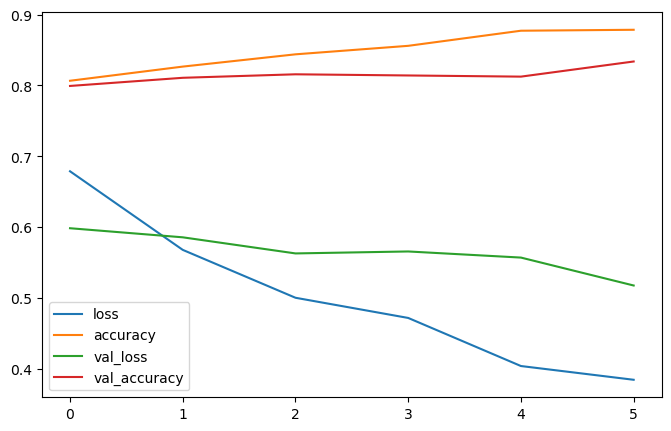

In [65]:
pd.DataFrame(history_fine_10_percent_data_aug.history).plot(figsize=(8, 5))

In [67]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3479999899864197, 0.6653333306312561, 0.7440000176429749, 0.7693333625793457, 0.8040000200271606, 0.8066666722297668, 0.8266666531562805, 0.843999981880188, 0.8560000061988831, 0.8773333430290222, 0.8786666393280029]


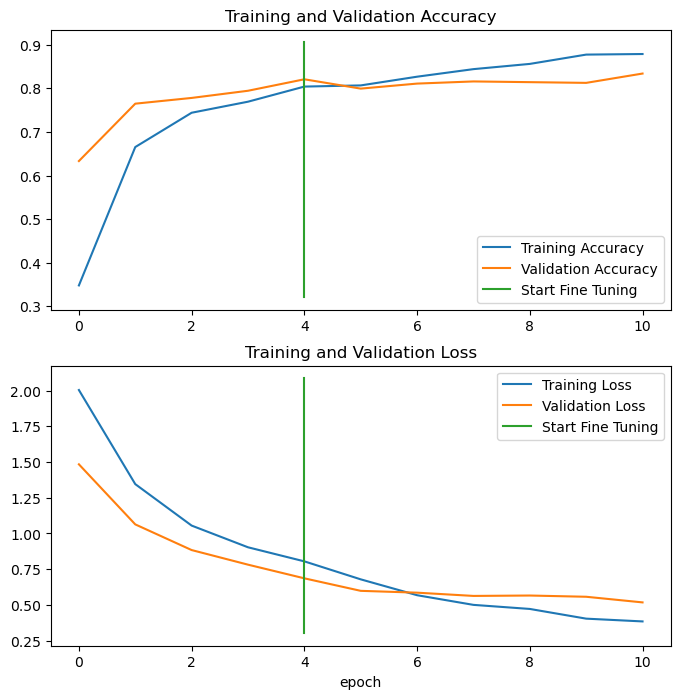

In [68]:
compare_historys(original_history=history2,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning an existing model all of the data 100%的数据

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.



In [71]:
# Download and unzip 10 classes of data with all images
if not os.path.exists("10_food_classes_all_data.zip"):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
if not os.path.exists("10_food_classes_all_data"):
    unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [72]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [73]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [75]:
model2.evaluate(test_data)

79/79 [==============================] - 26s 331ms/step - loss: 0.5160 - accuracy: 0.8288


[0.5159602761268616, 0.8288000226020813]

In [77]:
# 和results_fine_tune_10_percent相同，因为测试集是相同的，模型也是相同的
results_fine_tune_10_percent

[0.5159602761268616, 0.8288000226020813]

用相同的测试数据，和同一起点

To keep our experiments clean, we'll load a create a new instance of `model_2` using our `create_base_model()` function.

More specifically, we're trying to measure:
* **Experiment 3 (previous one)** - `model_2` with 10 layers fine-tuned for 5 more epochs on 10% of the data.
* **Experiment 4 (this one)** - `model_2` with layers fined-tuned for 5 more epochs on 100% on the data.

Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (`model_2` feature extractor trained for 5 epochs on 10% of the data).

Let's first create new instance of `model_2`.

In [78]:
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

In [79]:
model_2.load_weights(checkpoint_path)

In [80]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [81]:
len(model_2.trainable_variables)

2

In [82]:
model_2.evaluate(test_data)

79/79 [==============================] - 27s 327ms/step - loss: 0.6948 - accuracy: 0.8144


[0.6948036551475525, 0.8144000172615051]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint` (**Model 2**).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (**Model 3**).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (**Model 4**).

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [83]:
for i,layer in enumerate(model_2.layers):
    print(f"层数: {i} - layer: {layer.name},type: {type(layer)}, trainable: {layer.trainable}")

层数: 0 - layer: input_layer,type: <class 'keras.engine.input_layer.InputLayer'>, trainable: True
层数: 1 - layer: data_augmentation,type: <class 'keras.engine.sequential.Sequential'>, trainable: True
层数: 2 - layer: efficientnetb0,type: <class 'keras.engine.functional.Functional'>, trainable: False
层数: 3 - layer: global_average_pooling2d_3,type: <class 'keras.layers.pooling.GlobalAveragePooling2D'>, trainable: True
层数: 4 - layer: output_layer,type: <class 'keras.layers.core.dense.Dense'>, trainable: True


In [84]:
# 解冻model_2.的基础模型的最后10层
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [85]:
for i,layer in enumerate(model_2_base_model.layers):
    print(f"层数: {i} - layer: {layer.name},type: {type(layer)}, trainable: {layer.trainable}")

层数: 0 - layer: input_5,type: <class 'keras.engine.input_layer.InputLayer'>, trainable: False
层数: 1 - layer: rescaling_4,type: <class 'keras.layers.preprocessing.image_preprocessing.Rescaling'>, trainable: False
层数: 2 - layer: normalization_4,type: <class 'keras.layers.preprocessing.normalization.Normalization'>, trainable: False
层数: 3 - layer: stem_conv_pad,type: <class 'keras.layers.convolutional.ZeroPadding2D'>, trainable: False
层数: 4 - layer: stem_conv,type: <class 'keras.layers.convolutional.Conv2D'>, trainable: False
层数: 5 - layer: stem_bn,type: <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>, trainable: False
层数: 6 - layer: stem_activation,type: <class 'keras.layers.core.activation.Activation'>, trainable: False
层数: 7 - layer: block1a_dwconv,type: <class 'keras.layers.convolutional.DepthwiseConv2D'>, trainable: False
层数: 8 - layer: block1a_bn,type: <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>, trainable: False
层数: 9 - lay

In [86]:
len(model_2.trainable_variables)

12

In [87]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [89]:
fine_tune_epochs = initial_epochs + 5

history4 = model_2.fbit(train_data_10_classes_full,epochs=fine_tune_epochs,initial_epoch=history2.epoch[-1],
            validation_data=test_data,validation_steps=int(0.25*len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20250109-160056
Epoch 5/10


/root/miniconda3/envs/torchai/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


235/235 [==============================] - 103s 425ms/step - loss: 0.7371 - accuracy: 0.7640 - val_loss: 0.4521 - val_accuracy: 0.8520
Epoch 6/10
235/235 [==============================] - 94s 401ms/step - loss: 0.5931 - accuracy: 0.8060 - val_loss: 0.4303 - val_accuracy: 0.8635
Epoch 7/10
235/235 [==============================] - 98s 416ms/step - loss: 0.5282 - accuracy: 0.8305 - val_loss: 0.3939 - val_accuracy: 0.8618
Epoch 8/10
235/235 [==============================] - 98s 418ms/step - loss: 0.4824 - accuracy: 0.8433 - val_loss: 0.3753 - val_accuracy: 0.8816
Epoch 9/10
235/235 [==============================] - 99s 419ms/step - loss: 0.4450 - accuracy: 0.8552 - val_loss: 0.3307 - val_accuracy: 0.8914
Epoch 10/10
235/235 [==============================] - 98s 418ms/step - loss: 0.4135 - accuracy: 0.8668 - val_loss: 0.3752 - val_accuracy: 0.8701


In [90]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 26s 332ms/step - loss: 0.3430 - accuracy: 0.8860


[0.3429797291755676, 0.8859999775886536]

5
11
[0.3479999899864197, 0.6653333306312561, 0.7440000176429749, 0.7693333625793457, 0.8040000200271606, 0.7639999985694885, 0.8059999942779541, 0.8305333256721497, 0.8433333039283752, 0.8551999926567078, 0.8668000102043152]


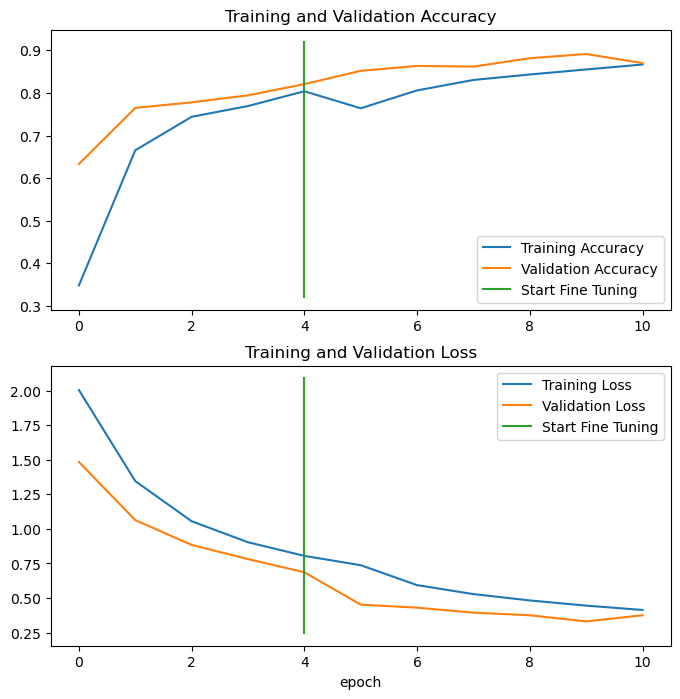

In [91]:
compare_historys(original_history=history2,
                 new_history=history4,
                 initial_epochs=5)

fine-tuning ,需要更多的数据，更多的参数需要更多的参数

Looks like that extra data helped! Those curves are looking great. And if we trained for longer, they might even keep improving.

## Viewing our experiment data on TensorBoard  tensorboard 对比效果

In [93]:
# 在本机,windows或者苹果笔记本上，ssh -L 6006:localhost:6006 root@42.81.80.145
# 再在命令行里运行如下命令  tensorboard --logdir ./tensorflow_hub/

In [ ]:
# !tensorboard --logdir ./transfer_learning/

2025-01-09 16:22:12.091011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-09 16:22:12.091036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-09 16:22:13.115688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-01-09 16:22:13.115713: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-01-09 16:22:13.115727: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iv-yddi5wlhj4qc6il2vxqe): /proc/driver/nvidia/version does not exist

NOTE: Using experimental fast data loading logic. To